In [1]:
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random

DATA_PATH = Path("../data/processed/snippets.npz")
SNIPPETS_PATH = Path("../data/processed/snippets.npz")
CONTRASTIVE_EMBED_PATH = Path("../data/processed/contrastive_embeddings.npz")

In [2]:
SNIPPETS_META_PATH = Path("../data/processed/snippets.npz")

def load_snippet_meta(meta_path=SNIPPETS_META_PATH):
    """
    Loads snippet-level metadata required for contrastive sampling:
      - song_ids (N,)
      - snippet_start_secs (N,)  (or start_qs if you prefer)
    """
    data = np.load(meta_path, allow_pickle=True)
    song_ids = data["song_ids"]
    start_secs = data.get("snippet_start_secs", None)
    if start_secs is None:
        raise ValueError("snippet_start_secs not found in snippets.npz — make sure your preprocessing saved it.")
    return song_ids, start_secs


In [3]:
# ---------------------
# Dataset & utilities
# ---------------------

class MelodySnippetsDataset(Dataset):
    def __init__(self, intervals, indices):
        """
        intervals: np.ndarray of shape (N, L)  -- already shifted to [0..V-1]
        indices:   np.ndarray of snippet indices to use for this split
        """
        self.intervals = np.asarray(intervals, dtype=np.int64)
        self.indices = np.asarray(indices, dtype=np.int64)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        seq = self.intervals[i]  # shape (L,)
        return torch.tensor(seq, dtype=torch.long)


def load_data_and_build_vocab(data_path: Path = DATA_PATH):
    """
    Load raw intervals from snippets.npz, shift them to [0..V-1],
    and compute vocab size consistent with the autoencoder pipeline.
    """
    data = np.load(data_path, allow_pickle=True)

    raw_intervals = data["intervals"]  # (N, L) actual pitch intervals (can be negative)
    song_ids = data["song_ids"]
    midi_filenames = data.get("midi_filenames", None)

    min_interval = int(raw_intervals.min())
    max_interval = int(raw_intervals.max())

    shifted_intervals = raw_intervals - min_interval  # now in [0..(max-min)]
    vocab_size = int(max_interval - min_interval + 1)

    print("Raw intervals min/max:", raw_intervals.min(), raw_intervals.max())
    print("Shifted intervals min/max:", shifted_intervals.min(), shifted_intervals.max())
    print("min_interval:", min_interval, "vocab_size:", vocab_size)

    return shifted_intervals.astype(np.int64), song_ids, midi_filenames, min_interval, vocab_size

def split_by_song(song_ids, train_frac=0.7, val_frac=0.15, seed=42):
    """
    Split songs (by unique song_id) into train/val/test.
    Returns three arrays of snippet indices: train_idx, val_idx, test_idx.
    """
    rng = np.random.default_rng(seed)
    unique_songs = np.unique(song_ids)
    rng.shuffle(unique_songs)

    n_songs = len(unique_songs)
    n_train = int(train_frac * n_songs)
    n_val = int(val_frac * n_songs)

    train_songs = unique_songs[:n_train]
    val_songs = unique_songs[n_train:n_train + n_val]
    test_songs = unique_songs[n_train + n_val:]

    def idx_for(songs_subset):
        mask = np.isin(song_ids, songs_subset)
        return np.where(mask)[0]

    train_idx = idx_for(train_songs)
    val_idx = idx_for(val_songs)
    test_idx = idx_for(test_songs)

    return train_idx, val_idx, test_idx


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MelodyEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=256, proj_dim=128, num_layers=1):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, embed_dim)
        self.encoder_rnn = nn.GRU(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
        )
        # hidden_dim * 2 because bidirectional
        self.proj = nn.Linear(hidden_dim * 2, proj_dim)

    def forward(self, x):
        """
        x: (B, L) token ids
        returns: (B, D) L2-normalized embedding
        """
        emb = self.token_embed(x)           # (B, L, E)
        _, h_n = self.encoder_rnn(emb)      # (2*num_layers, B, H)
        h_fw = h_n[-2]                      # (B, H)
        h_bw = h_n[-1]                      # (B, H)
        h_cat = torch.cat([h_fw, h_bw], dim=-1)  # (B, 2H)
        z = self.proj(h_cat)               # (B, D)
        z = F.normalize(z, dim=-1)         # L2-normalize for cosine similarity
        return z


In [5]:
class MelodyPairsDataset(Dataset):
    def __init__(self, intervals, song_ids, start_secs, indices, neighbor_sec_window=20.0):
        """
        intervals: np.ndarray (N, L)
        song_ids: np.ndarray (N,)
        start_secs: np.ndarray (N,) snippet start time in seconds
        indices: subset of snippet indices to use for contrastive training
        neighbor_sec_window: float, max time distance in seconds for positives
                             (controls how "local" positives are)
        """
        self.intervals = intervals
        self.song_ids = song_ids
        self.start_secs = start_secs
        self.indices = np.array(indices, dtype=int)
        self.neighbor_sec_window = float(neighbor_sec_window)

        # Build mapping: song_id -> sorted list of (idx, start_sec)
        song_to_list = {}
        for i in self.indices:
            sid = int(song_ids[i])
            t = float(start_secs[i])
            song_to_list.setdefault(sid, []).append((i, t))

        # For each song, sort by time
        self.song_to_snips = {}
        for sid, items in song_to_list.items():
            items_sorted = sorted(items, key=lambda x: x[1])  # sort by start_sec
            self.song_to_snips[sid] = items_sorted

        # Anchor indices: any snippet whose song has at least 2 snippets
        self.anchor_indices = []
        for sid, items in self.song_to_snips.items():
            if len(items) >= 2:
                self.anchor_indices.extend([i for (i, _) in items])

        self.anchor_indices = np.array(self.anchor_indices, dtype=int)
        print(
            f"MelodyPairsDataset: {len(self.anchor_indices)} anchor snippets "
            f"from {len(self.song_to_snips)} songs (only songs with >=2 snippets used)."
        )

    def __len__(self):
        return len(self.anchor_indices)

    def __getitem__(self, idx):
        anchor_i = self.anchor_indices[idx]
        sid = int(self.song_ids[anchor_i])
        t_anchor = float(self.start_secs[anchor_i])

        # Get all snippets for this song, sorted by time
        snips = self.song_to_snips[sid]  # list of (idx, t)

        # Find index of anchor in this list
        pos_in_list = None
        for j, (snip_idx, t) in enumerate(snips):
            if snip_idx == anchor_i:
                pos_in_list = j
                break

        # Safety check
        if pos_in_list is None:
            # Fallback: treat positive as itself (rare)
            pos_i = anchor_i
        else:
            # Candidates within +/- neighbor_sec_window in time
            candidates = []
            for snip_idx, t in snips:
                if snip_idx == anchor_i:
                    continue
                if abs(t - t_anchor) <= self.neighbor_sec_window:
                    candidates.append(snip_idx)

            # If no local candidates found, fall back to any same-song snippet
            if not candidates:
                candidates = [snip_idx for snip_idx, _ in snips if snip_idx != anchor_i]

            if candidates:
                pos_i = random.choice(candidates)
            else:
                pos_i = anchor_i  # degenerately same (very unlikely)

        anchor_seq = self.intervals[anchor_i]  # (L,)
        pos_seq    = self.intervals[pos_i]     # (L,)

        return (
            torch.tensor(anchor_seq, dtype=torch.long),
            torch.tensor(pos_seq, dtype=torch.long),
        )


In [6]:
def contrastive_loss(z_a, z_p, temperature=0.1):
    """
    z_a: (B, D) anchor embeddings (L2-normalized)
    z_p: (B, D) positive embeddings (L2-normalized)
    Returns scalar loss (symmetric InfoNCE).
    """
    B, D = z_a.shape

    # Cosine similarities: (B, B)
    sim_matrix = z_a @ z_p.T  # since vectors are normalized, this is cosine similarity

    # Scale by temperature
    logits = sim_matrix / temperature

    # For anchor->positive: correct positive for i is i
    labels = torch.arange(B, device=z_a.device)

    loss_a2p = F.cross_entropy(logits, labels)

    # Symmetric: positive->anchor
    loss_p2a = F.cross_entropy(logits.T, labels)

    loss = 0.5 * (loss_a2p + loss_p2a)
    return loss



In [7]:
from torch.utils.data import DataLoader

CONTRASTIVE_EMBED_PATH = Path("../data/processed/contrastive_embeddings.npz")

def train_contrastive_encoder(
    batch_size=256,
    num_epochs=100,
    lr=1e-3,
    temperature=0.1,
    neighbor_sec_window=20.0,
    device=None,
):
    # Load interval data + vocab
    intervals, song_ids, midi_filenames, min_interval, vocab_size = load_data_and_build_vocab()

    # Load snippet meta (start_secs)
    song_ids_meta, start_secs = load_snippet_meta()
    # Sanity check: song_ids alignment
    assert np.array_equal(song_ids, song_ids_meta), "song_ids mismatch between intervals and meta!"

    # We will train contrastive encoder only on train songs
    train_idx, val_idx, test_idx = split_by_song(song_ids)
    print(f"Total snippets: {intervals.shape[0]}")
    print(f"Train/Val/Test sizes: {len(train_idx)}, {len(val_idx)}, {len(test_idx)}")
    print(f"Vocab size: {vocab_size}, min_interval={min_interval}")

    train_pairs_ds = MelodyPairsDataset(
        intervals=intervals,
        song_ids=song_ids,
        start_secs=start_secs,
        indices=train_idx,
        neighbor_sec_window=neighbor_sec_window,
    )

    train_loader = DataLoader(
        train_pairs_ds,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,  # keep batches aligned for contrastive loss
    )

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = MelodyEncoder(
        vocab_size=vocab_size,
        embed_dim=128,
        hidden_dim=256,
        proj_dim=128,
        num_layers=1,
    )
    model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    epoch_losses = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        n_batches = 0

        for batch in train_loader:
            anchors, positives = batch  # each: (B, L)
            anchors = anchors.to(device)
            positives = positives.to(device)

            optimizer.zero_grad()
            z_a = model(anchors)    # (B, D)
            z_p = model(positives)  # (B, D)

            loss = contrastive_loss(z_a, z_p, temperature=temperature)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            n_batches += 1

        avg_loss = total_loss / max(n_batches, 1)
        epoch_losses.append(avg_loss)
        print(f"Epoch {epoch:02d} | contrastive_loss={avg_loss:.4f}")

    # After training, compute embeddings for ALL snippets (train+val+test)
    model.eval()
    all_embeddings = []

    full_ds = MelodySnippetsDataset(intervals, np.arange(intervals.shape[0]))
    full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

    with torch.no_grad():
        for batch in full_loader:
            batch = batch.to(device)
            z = model(batch)  # (B, D)
            all_embeddings.append(z.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)  # (N, D)
    print("All contrastive embeddings shape:", all_embeddings.shape)

    CONTRASTIVE_EMBED_PATH.parent.mkdir(parents=True, exist_ok=True)
    np.savez_compressed(
        CONTRASTIVE_EMBED_PATH,
        embeddings=all_embeddings,
        song_ids=song_ids,
        min_interval=min_interval,
        vocab_size=vocab_size,
        midi_filenames=midi_filenames,
        # if desired, also copy genres/snippet_labels/start/end_secs from snippets.npz here
    )
    print(f"Saved contrastive embeddings to {CONTRASTIVE_EMBED_PATH}")

    return {
        "train_idx": train_idx,
        "val_idx": val_idx,
        "test_idx": test_idx,
        "epoch_losses": epoch_losses,
        "model": model,
    }


In [11]:
from pathlib import Path
import numpy as np

CONTRASTIVE_EMBED_PATH = Path("../data/processed/contrastive_embeddings.npz")

def load_contrastive_embeddings(embed_path=CONTRASTIVE_EMBED_PATH):
    """
    Load snippet-level contrastive embeddings and metadata.
    Returns:
        embeddings      : (N_snips, D)
        song_ids        : (N_snips,)
        midi_filenames  : (N_songs,) or None
        genres          : (N_snips,) or None
        snippet_labels  : (N_snips,) or None
        start_secs      : (N_snips,) or None
        end_secs        : (N_snips,) or None
    """
    data = np.load(embed_path, allow_pickle=True)

    embeddings = data["embeddings"]
    song_ids = data["song_ids"]
    midi_filenames = data.get("midi_filenames", None)
    genres = data.get("genres", None)
    snippet_labels = data.get("snippet_labels", None)
    start_secs = data.get("snippet_start_secs", None)
    end_secs = data.get("snippet_end_secs", None)

    return embeddings, song_ids, midi_filenames, genres, snippet_labels, start_secs, end_secs


def cosine_sim(a, b):
    """
    a: (N, D)
    b: (D,) or (1, D)
    returns: (N,)
    """
    a_norm = a / (np.linalg.norm(a, axis=1, keepdims=True) + 1e-8)
    b_norm = b / (np.linalg.norm(b) + 1e-8)
    return np.dot(a_norm, b_norm)


In [12]:
def retrieve_with_contrastive(query_idx, top_k=10):
    """
    Retrieve top_k nearest neighbors for a given snippet index
    using contrastive embeddings (cosine similarity).
    """
    (embeddings, song_ids, midi_filenames,
     genres, snippet_labels, start_secs, end_secs) = load_contrastive_embeddings()

    N, D = embeddings.shape
    if query_idx < 0 or query_idx >= N:
        raise ValueError(f"query_idx {query_idx} out of range [0, {N-1}]")

    q_emb = embeddings[query_idx]
    sims = cosine_sim(embeddings, q_emb)

    sorted_idx = np.argsort(-sims)  # descending

    q_sid = int(song_ids[query_idx])
    q_genre = genres[query_idx] if genres is not None else "unknown"
    q_file = midi_filenames[q_sid] if midi_filenames is not None and q_sid < len(midi_filenames) else "N/A"
    q_label = snippet_labels[query_idx] if snippet_labels is not None else ""
    q_t0 = float(start_secs[query_idx]) if start_secs is not None else None
    q_t1 = float(end_secs[query_idx]) if end_secs is not None else None

    print(f"Query snippet {query_idx}:")
    print(f"  song_id = {q_sid}, genre = {q_genre}")
    print(f"  file    = {q_file}")
    if q_label:
        print(f"  label   = {q_label}")
    if q_t0 is not None and q_t1 is not None:
        print(f"  approx time: {q_t0:.2f}s → {q_t1:.2f}s")

    print(f"\nTop {top_k} neighbors by cosine similarity (contrastive):")
    printed = 0
    for idx in sorted_idx:
        if idx == query_idx:
            continue
        sid = int(song_ids[idx])
        g = genres[idx] if genres is not None else "unknown"
        fname = midi_filenames[sid] if midi_filenames is not None and sid < len(midi_filenames) else "N/A"
        label = snippet_labels[idx] if snippet_labels is not None else ""
        s0 = float(start_secs[idx]) if start_secs is not None else None
        s1 = float(end_secs[idx]) if end_secs is not None else None

        print(f"  idx={idx:5d}, sim={sims[idx]:.3f}, song_id={sid}, genre={g}, file={fname}")
        if label:
            print(f"       label: {label}")
        if s0 is not None and s1 is not None:
            print(f"       time: {s0:.2f}s → {s1:.2f}s")
        printed += 1
        if printed >= top_k:
            break


Raw intervals min/max: -94 89
Shifted intervals min/max: 0 183
min_interval: -94 vocab_size: 184
Total snippets: 34513
Train/Val/Test sizes: 24131, 5089, 5293
Vocab size: 184, min_interval=-94
MelodyPairsDataset: 24119 anchor snippets from 638 songs (only songs with >=2 snippets used).
Using device: cuda
Epoch 01 | contrastive_loss=4.2584
Epoch 02 | contrastive_loss=3.3275
Epoch 03 | contrastive_loss=3.0478
Epoch 04 | contrastive_loss=2.8780
Epoch 05 | contrastive_loss=2.7610
Epoch 06 | contrastive_loss=2.6120
Epoch 07 | contrastive_loss=2.4567
Epoch 08 | contrastive_loss=2.3344
Epoch 09 | contrastive_loss=2.1958
Epoch 10 | contrastive_loss=2.0554
Epoch 11 | contrastive_loss=1.9228
Epoch 12 | contrastive_loss=1.7955
Epoch 13 | contrastive_loss=1.6525
Epoch 14 | contrastive_loss=1.5434
Epoch 15 | contrastive_loss=1.4232
Epoch 16 | contrastive_loss=1.3135
Epoch 17 | contrastive_loss=1.2206
Epoch 18 | contrastive_loss=1.1470
Epoch 19 | contrastive_loss=1.0599
Epoch 20 | contrastive_loss=1

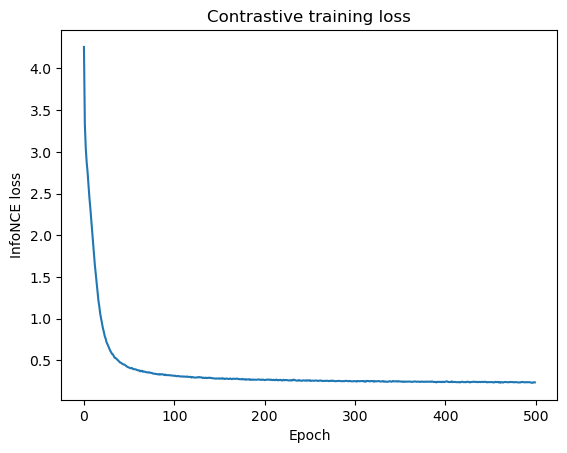

In [8]:
# Example training call
info_contrastive = train_contrastive_encoder(
    batch_size=256,
    num_epochs=500,
    lr=1e-3,
    temperature=0.1,
    neighbor_sec_window=20.0,
)

import matplotlib.pyplot as plt

plt.plot(info_contrastive["epoch_losses"])
plt.title("Contrastive training loss")
plt.xlabel("Epoch")
plt.ylabel("InfoNCE loss")
plt.show()

In [9]:
contrastive_model = info_contrastive["model"]

CONTRASTIVE_MODEL_PATH = Path("../models/contrastive_encoder.pt")
CONTRASTIVE_MODEL_PATH.parent.mkdir(parents=True, exist_ok=True)
torch.save(contrastive_model.state_dict(), CONTRASTIVE_MODEL_PATH)
print("Saved contrastive encoder to", CONTRASTIVE_MODEL_PATH)

Saved contrastive encoder to ../models/contrastive_encoder.pt


In [13]:
retrieve_with_contrastive(query_idx=202, top_k=10)

Query snippet 202:
  song_id = 4, genre = unknown
  file    = Axel_F_1.mid

Top 10 neighbors by cosine similarity (contrastive):
  idx=  205, sim=1.000, song_id=4, genre=unknown, file=Axel_F_1.mid
  idx=  208, sim=0.803, song_id=4, genre=unknown, file=Axel_F_1.mid
  idx=  213, sim=0.787, song_id=4, genre=unknown, file=Axel_F_1.mid
  idx=  203, sim=0.774, song_id=4, genre=unknown, file=Axel_F_1.mid
  idx=23890, sim=0.684, song_id=651, genre=unknown, file=Dont Stand So Close to Me.mid
  idx=18041, sim=0.671, song_id=491, genre=unknown, file=JoJo_Leave_get_out.mid
  idx= 3264, sim=0.668, song_id=85, genre=unknown, file=sweet_caroline6_A130.mid
  idx=28190, sim=0.664, song_id=749, genre=unknown, file=Feel_So_High.mid
  idx= 4508, sim=0.663, song_id=114, genre=unknown, file=I Am the City.mid
  idx= 3259, sim=0.662, song_id=85, genre=unknown, file=sweet_caroline6_A130.mid


In [14]:
from collections import Counter

def aggregate_contrastive_by_song(embed_path=CONTRASTIVE_EMBED_PATH):
    """
    Aggregate snippet-level contrastive embeddings to song-level
    by averaging all snippet embeddings per song_id.

    Returns:
        song_embs      : (N_songs, D)
        song_genres    : (N_songs,)
        song_names     : (N_songs,)
        unique_song_ids: (N_songs,)
        pcs            : (N_songs, K) if you later add PCA
    """
    data = np.load(embed_path, allow_pickle=True)

    embeddings = data["embeddings"]        # (N_snips, D)
    song_ids_snip = data["song_ids"]       # (N_snips,)
    midi_filenames = data.get("midi_filenames", None)
    genres_snip = data.get("genres", None)

    unique_song_ids = np.unique(song_ids_snip)
    song_embs = []
    song_genres = []
    song_names = []

    for sid in unique_song_ids:
        mask = (song_ids_snip == sid)
        emb_mean = embeddings[mask].mean(axis=0)
        song_embs.append(emb_mean)

        if genres_snip is not None:
            g_vals = genres_snip[mask]
            # most common genre among snippets of this song
            counts = Counter(g_vals)
            song_genres.append(counts.most_common(1)[0][0])
        else:
            song_genres.append("unknown")

        if midi_filenames is not None and sid < len(midi_filenames):
            song_names.append(midi_filenames[sid])
        else:
            song_names.append(f"song_{sid}")

    song_embs = np.vstack(song_embs)
    song_genres = np.array(song_genres, dtype=object)
    song_names = np.array(song_names, dtype=object)

    return song_embs, song_genres, song_names, unique_song_ids


In [15]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def compute_contrastive_pca(num_components: int = 5):
    """
    Run PCA on song-level contrastive embeddings.
    Returns:
        song_embs      : (N_songs, D)
        song_genres    : (N_songs,)
        song_names     : (N_songs,)
        song_ids       : (N_songs,)
        pcs            : (N_songs, num_components)
        pca            : PCA object
    """
    song_embs, song_genres, song_names, song_ids = aggregate_contrastive_by_song()
    pca = PCA(n_components=num_components, random_state=42)
    pcs = pca.fit_transform(song_embs)

    print("Contrastive PCA explained variance ratios:")
    for i, r in enumerate(pca.explained_variance_ratio_):
        print(f"  PC{i+1}: {r:.4f}")

    return song_embs, song_genres, song_names, song_ids, pcs, pca

In [17]:
def plot_contrastive_umap_by_genre(n_neighbors=20, min_dist=0.1, metric="cosine"):
    """
    UMAP projection of song-level contrastive embeddings, colored by genre.
    """
    song_embs, song_genres, song_names, song_ids = aggregate_contrastive_by_song()

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_2d = reducer.fit_transform(song_embs)  # (N_songs, 2)

    # Map genres to integer colors
    unique_genres = np.unique(song_genres)
    genre_to_id = {g: i for i, g in enumerate(unique_genres)}
    genre_ids = np.array([genre_to_id[g] for g in song_genres])

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                          c=genre_ids, s=25, alpha=0.8, cmap="tab20")

    handles, _ = scatter.legend_elements(num=len(unique_genres))
    plt.legend(handles, unique_genres, title="Genre",
               bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.title("UMAP of song-level contrastive embeddings (colored by genre)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


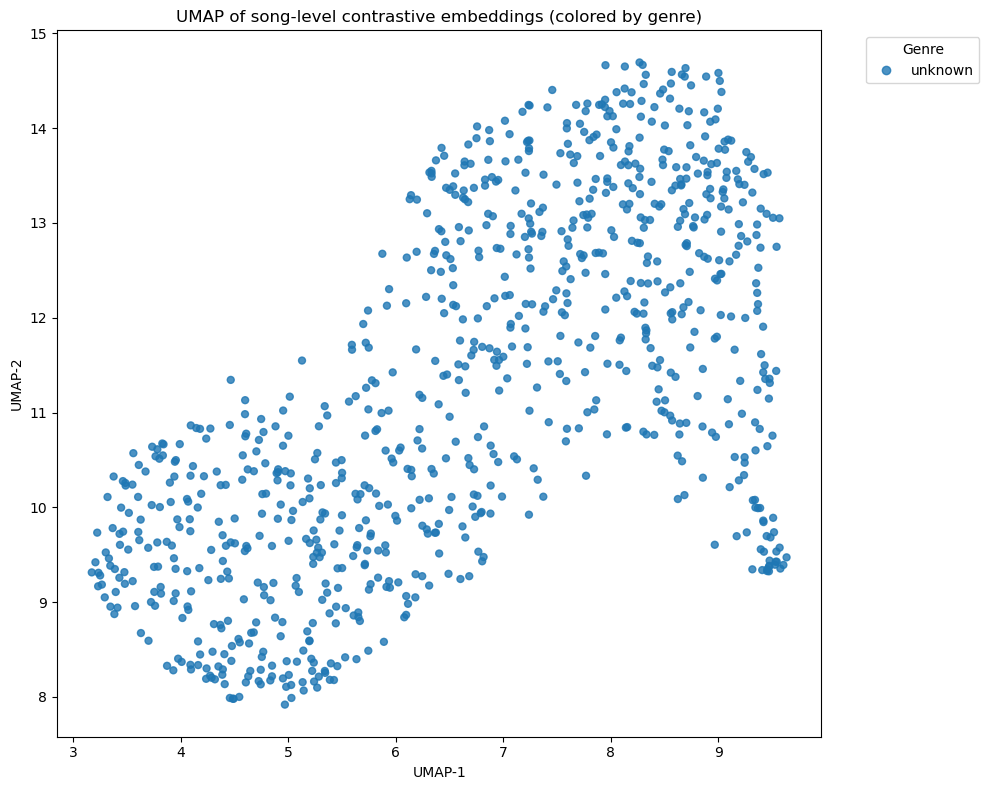

In [18]:
plot_contrastive_umap_by_genre()

In [19]:
def plot_contrastive_umap_by_pc1(n_neighbors=20, min_dist=0.1, metric="cosine"):
    """
    UMAP projection of song-level contrastive embeddings,
    colored by PCA PC1 value.
    """
    song_embs, song_genres, song_names, song_ids, pcs, pca = compute_contrastive_pca(num_components=5)
    pc1 = pcs[:, 0]

    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric,
        random_state=42,
    )
    emb_2d = reducer.fit_transform(song_embs)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1],
                          c=pc1, s=25, alpha=0.8, cmap="coolwarm")
    plt.colorbar(scatter, label="PC1 value")

    plt.title("UMAP of song-level contrastive embeddings (colored by PC1)")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.tight_layout()
    plt.show()

Contrastive PCA explained variance ratios:
  PC1: 0.0616
  PC2: 0.0553
  PC3: 0.0527
  PC4: 0.0513
  PC5: 0.0464


/opt/conda/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


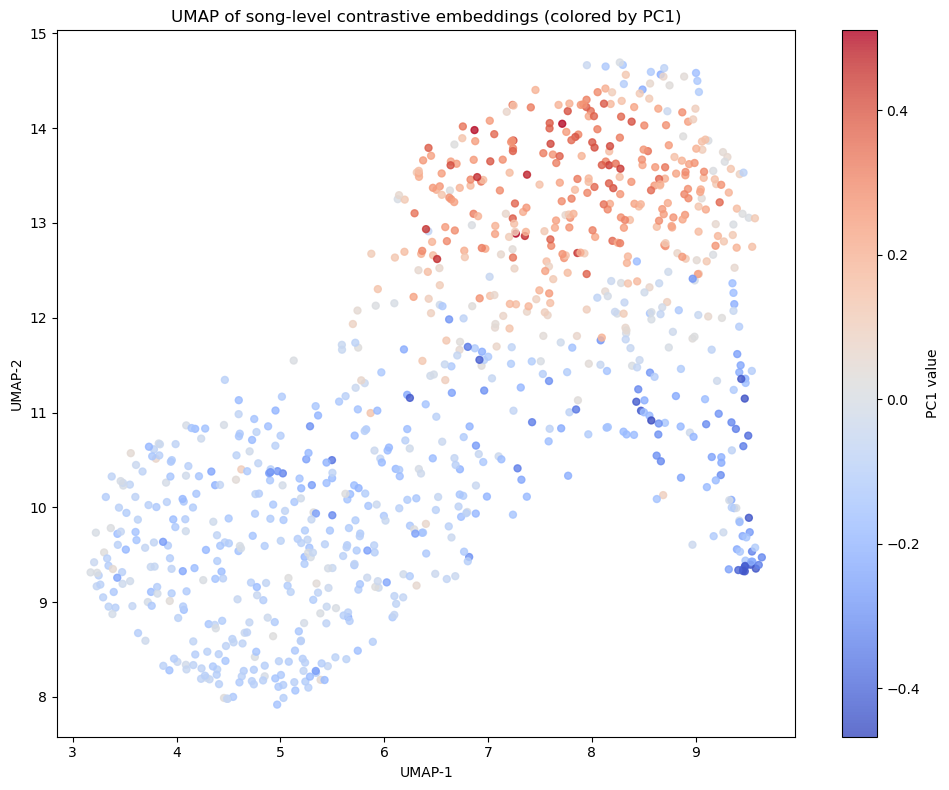

In [20]:
plot_contrastive_umap_by_pc1()